In [1]:
import collections
import random

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import _LRScheduler

from env import Minesweeper

In [2]:
class CNN(nn.Module):
    def __init__(self, kernel_size=3):
        super(CNN, self).__init__()

        self.kernel_size = kernel_size
        self.padding = kernel_size // 2

        self.layer1 = nn.Conv2d(10, 25, kernel_size=self.kernel_size, padding=self.padding)
        self.layer2 = nn.Conv2d(25, 25, kernel_size=self.kernel_size, padding=self.padding)
        self.layer3 = nn.Conv2d(25, 64, kernel_size=self.kernel_size, padding=self.padding)
        self.layer4 = nn.Conv2d(64, 1, kernel_size=self.kernel_size, padding=self.padding)

        self.relu = F.relu
        self.softmax = F.softmax

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.layer4(x)
        x = x.view(x.size(0), -1)
        return x

In [3]:
class MinesweeperEnvWrapper():
    def __init__(self, difficulty="beginner", display=False):
        self.display = display
        self.env = Minesweeper(difficulty)
        self.state = self.preprocess_state(self.env.O)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    def reset(self):
        self.env.reset()
        self.state = self.preprocess_state(self.env.O)
        return self.state
    
    def step(self, action):
        status = self.env.take_action(action)   
        self.state = self.preprocess_state(self.env.O)
        next_state = self.state
        done = bool(status)
        reward = self.reward(status)
        if self.display:
            self.env.print_env()
            print(f"Reward: {reward}")
        return next_state, reward, done
    
    def reward(self, status):
        if status == 0:  # if the model uncovers a safe tile
            return 1
        elif status == 1:  # if the model uncovers a mine
            return -50
        elif status == 2:  # if the model wins
            return 50
        else:
            raise ValueError("Invalid status or error flag.")
    
    def preprocess_state(self, observed_grid):
        encoded_list = np.zeros((10, self.env.n_rows, self.env.n_cols))
        test_value_list = [-2, 0, 1, 2, 3, 4, 5, 6, 7, 8]
        for i in range(10):
            # When tile is test_value_list[i] we encode it as 1, otherwise 0
            encoded_list[i] = np.where(observed_grid == test_value_list[i], 1, 0)
        return encoded_list

In [4]:
class EpsilonGreedy:
    def __init__(self, epsilon_start: float, epsilon_min: float, epsilon_decay:float, envWrapper: MinesweeperEnvWrapper, q_network: CNN):
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.envWrapper = envWrapper
        self.q_network = q_network
        self.device = self.envWrapper.device

    def __call__(self, state: np.ndarray, display=False) -> np.int64:
        valid_actions = np.where(state[0].flatten() == 1)[0]
        if np.random.rand() < self.epsilon:
            if display:
                print('Random action')
            action = np.random.choice(valid_actions)
        else:
            state_tensor = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
            q_values = self.q_network(state_tensor).detach().cpu().numpy().flatten()
            if display:
                print(f'Q-values: {q_values}')
            invalid_actions = np.delete(np.arange(q_values.size), valid_actions)
            q_values[invalid_actions] = -np.inf
            action = np.argmax(q_values)
        return action

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

In [5]:
class MinimumExponentialLR(torch.optim.lr_scheduler.ExponentialLR):
    def __init__(self, optimizer: torch.optim.Optimizer, lr_decay: float, last_epoch: int = -1, min_lr: float = 1e-6):
        self.min_lr = min_lr
        super().__init__(optimizer, lr_decay, last_epoch=last_epoch)

    def get_lr(self) -> list[float]:
        return [max(base_lr * self.gamma ** self.last_epoch, self.min_lr) for base_lr in self.base_lrs]

In [6]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self):
        return random.choice(self.buffer)

    def __len__(self):
        return len(self.buffer)

In [7]:
class Solver():
    def __init__(self, envWrapper: MinesweeperEnvWrapper, q_network: CNN, target_network: CNN):
        self.envWrapper = envWrapper
        self.q_network = q_network
        self.target_network = target_network
        self.device = self.envWrapper.device

    def test_agent(self, num_episodes: int = 1) -> list[int]:  
        episode_reward_list = []

        for _ in range(num_episodes):
            state = self.envWrapper.reset()
            done = False
            episode_reward = 0

            while not done:
                # Convert the state to a PyTorch tensor and add a batch dimension (unsqueeze)
                state_tensor = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
                with torch.no_grad():
                    q_values = self.q_network(state_tensor).detach().cpu().numpy().flatten()
                invalid_actions = np.where(state[0].flatten() == 0)[0] 
                q_values[invalid_actions] = -np.inf
                action = np.argmax(q_values)             
                next_state, reward, done = self.envWrapper.step(action)               
                state = next_state
                episode_reward += reward

            episode_reward_list.append(episode_reward)
            print(f"Episode reward: {episode_reward}")

        return episode_reward_list
    

    def train_agent(
            self, 
            optimizer: torch.optim.Optimizer, 
            loss_fn: callable, 
            epsilon_greedy: EpsilonGreedy, 
            lr_scheduler: _LRScheduler, 
            num_episodes: int, 
            gamma: float, 
            replay_buffer: ReplayBuffer,
            target_network_sync_period: int,
            print_every: int
    ) -> list[float]:
        episode_reward_list = []

        for i in range(1, num_episodes):
            state = self.envWrapper.reset()
            episode_reward = 0
   
            while True:
                action = epsilon_greedy(state, display=False)
                next_state, reward, done = self.envWrapper.step(action)
                episode_reward += reward

                replay_buffer.add(state, action, reward, next_state, done)

                replayed_state, replayed_action, replayed_reward, replayed_next_state, replayed_done = replay_buffer.sample()
                total_loss = 0 

                replayed_next_state_tensor = torch.tensor(replayed_next_state, dtype=torch.float32, device=self.device).unsqueeze(0)
                with torch.no_grad():
                    replayed_next_q_values = self.target_network(replayed_next_state_tensor)
                replayed_target = replayed_reward + (1-replayed_done) * gamma * torch.max(replayed_next_q_values)
                replayed_state_tensor = torch.tensor(replayed_state, dtype=torch.float32, device=self.device).unsqueeze(0)
                replayed_q_values = self.q_network(replayed_state_tensor)
                loss = loss_fn(replayed_q_values[0, replayed_action], replayed_target)
                total_loss += loss

                optimizer.zero_grad()
                total_loss.backward()
                optimizer.step()
                lr_scheduler.step()

                if done:
                    break
                
                state = next_state
            
            if i % target_network_sync_period == 0:
                self.target_network.load_state_dict(self.q_network.state_dict())

            if i % print_every == 0:
                print(f"Episode: {i}, Reward: {episode_reward}, Epsilon: {epsilon_greedy.epsilon}, LR: {lr_scheduler.get_lr()[0]}, Loss: {total_loss.item()}")
            
            episode_reward_list.append(episode_reward)
            epsilon_greedy.decay_epsilon()

        return episode_reward_list
    


In [8]:
envWrapper = MinesweeperEnvWrapper(difficulty="beginner", display=False)
q_network = CNN().to(envWrapper.device)
target_network = CNN().to(envWrapper.device)
optimizer = torch.optim.Adam(q_network.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
epsilon_greedy = EpsilonGreedy(epsilon_start=0.9, epsilon_min=0.05, epsilon_decay=0.999, envWrapper=envWrapper, q_network=q_network)
lr_scheduler = MinimumExponentialLR(optimizer, lr_decay=0.9999, min_lr=1e-6)
solver = Solver(envWrapper, q_network, target_network)
buffer = ReplayBuffer(capacity=10000)

In [9]:
episode_reward_list = solver.train_agent(
    optimizer=optimizer, 
    loss_fn=loss_fn, 
    epsilon_greedy=epsilon_greedy, 
    lr_scheduler=lr_scheduler, 
    num_episodes=10000, 
    gamma=0.99, 
    replay_buffer=buffer, 
    print_every=500, 
    target_network_sync_period=250
)

Episode: 500, Reward: -43, Epsilon: 0.5462873377127788, LR: 0.0007124703718089029, Loss: 1544.2989501953125
Episode: 1000, Reward: -50, Epsilon: 0.3312571394333005, LR: 0.0004377351167803285, Loss: 230.9678955078125
Episode: 1500, Reward: -33, Epsilon: 0.20086735468729922, LR: 0.0002380982787112695, Loss: 0.3863440752029419
Episode: 2000, Reward: -48, Epsilon: 0.12180173459234177, LR: 0.00012112822944569229, Loss: 602.7326049804688
Episode: 2500, Reward: -32, Epsilon: 0.07385800730436627, LR: 6.0317053194000005e-05, Loss: 2747.7177734375
Episode: 3000, Reward: -46, Epsilon: 0.05, LR: 3.313814125030435e-05, Loss: 7957.72021484375
Episode: 3500, Reward: -49, Epsilon: 0.05, LR: 1.922396534638906e-05, Loss: 61310.765625
Episode: 4000, Reward: -47, Epsilon: 0.05, LR: 1.1923769134544702e-05, Loss: 134068.796875
Episode: 4500, Reward: -50, Epsilon: 0.05, LR: 7.932065218773678e-06, Loss: 9458082.0
Episode: 5000, Reward: -38, Epsilon: 0.05, LR: 5.157190252230028e-06, Loss: 24651594.0
Episode: 5

In [10]:
print(solver.test_agent(num_episodes=5))

Episode reward: -50
Episode reward: -49
Episode reward: -28
Episode reward: -48
Episode reward: -49
[-50, -49, -28, -48, -49]


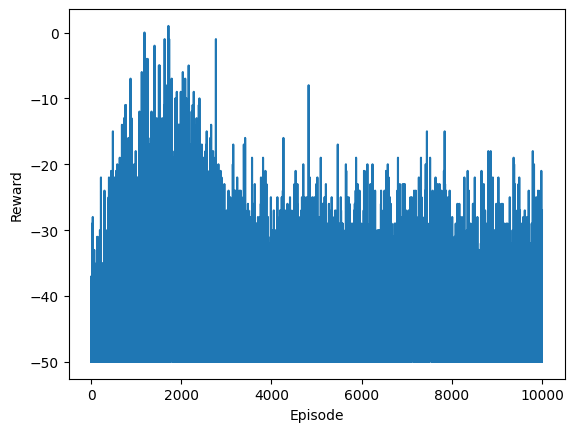

In [11]:
plt.plot(episode_reward_list)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

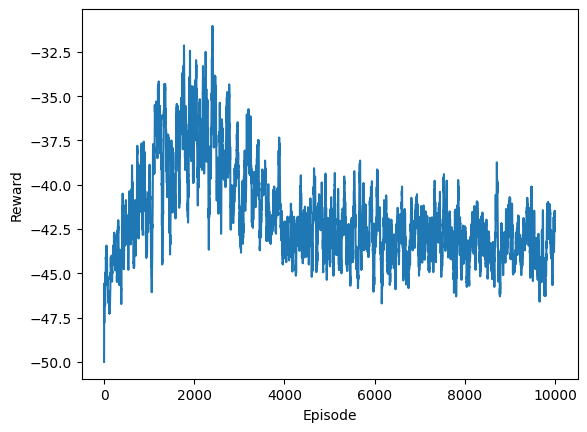

In [12]:
rewards_df = pd.DataFrame(episode_reward_list, columns=['Reward'])
N = 30
smoothed_rewards = rewards_df.rolling(window=N, min_periods=1).mean()

plt.plot(smoothed_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()